In [1]:
import numpy as np
from numpy.random import RandomState
from numpy.polynomial import Polynomial
from matplotlib.pyplot import plot
from scipy.stats.distributions import lognorm, rv_frozen

In [2]:
class GeometricBrownianMotion:
    '''Geometric Brownian Motion.(with optional drift).'''
    def __init__(self, mu: float=0.0, sigma: float=1.0):
        self.mu = mu
        self.sigma = sigma

    def simulate(self, t: np.array, n: int, rnd: np.random.RandomState) \
            -> np.array:
        assert t.ndim == 1, 'One dimensional time vector required'
        assert t.size > 0, 'At least one time point is required'
        dt = np.concatenate((t[0:1], np.diff(t)))
        assert (dt >= 0).all(), 'Increasing time vector required'
        # transposed simulation for automatic broadcasting
        dW = (rnd.normal(size=(t.size, n)).T * np.sqrt(dt)).T
        W = np.cumsum(dW, axis=0)
        return np.exp(self.sigma * W.T + (self.mu - self.sigma**2 / 2) * t).T

    def distribution(self, t: float) -> rv_frozen:
        mu_t = (self.mu - self.sigma**2/2) * t
        sigma_t = self.sigma * np.sqrt(t)
        return lognorm(scale=np.exp(mu_t), s=sigma_t)

In [3]:
use_test_data = False

if use_test_data:
    t = np.linspace(0, 3, 4)
    r = 0.06
    X = np.array([
            [1.00, 1.09, 1.08, 1.34],
            [1.00, 1.16, 1.26, 1.54],
            [1.00, 1.22, 1.07, 1.03],
            [1.00, 0.93, 0.97, 0.92],
            [1.00, 1.11, 1.56, 1.52],
            [1.00, 0.76, 0.77, 0.90],
            [1.00, 0.92, 0.84, 1.01],
            [1.00, 0.88, 1.22, 1.34]]).T
else:
    r = 0.0
    sigma = 0.15
    gbm = GeometricBrownianMotion(mu=r, sigma=sigma)
    t = np.linspace(0, 5, 12*5)
    rnd = RandomState(seed=1234)
    X = gbm.simulate(t, 50, rnd)

X.shape

(60, 50)

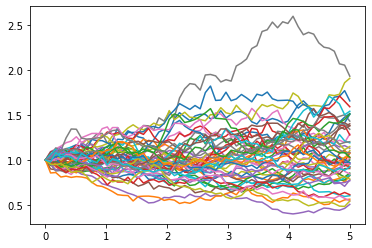

In [4]:
plot(t, X);

In [5]:
def exercise_value(s):
    return np.maximum(1.1 - s, 0)

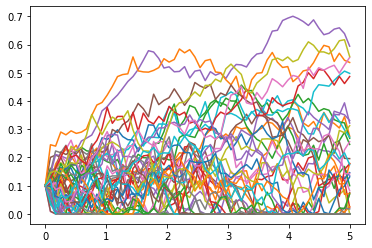

In [6]:
plot(t, exercise_value(X));

In [7]:
def fit(x, y):
    return Polynomial.fit(x, y, 2)

In [8]:
p = fit(X[-2, :], exercise_value(X[-1, :]))
p

Polynomial([-0.00060335, -0.25695195,  0.35613392], domain=[0.46132074, 2.05354718], window=[-1.,  1.])

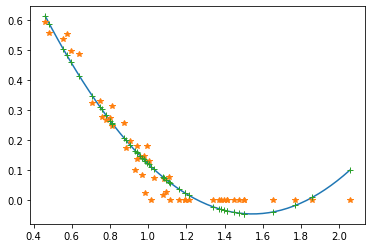

In [9]:
_x = np.linspace(np.min(X[-2, :]), np.max(X[-2, :]))
plot(_x, p(_x));
plot(X[-2, :], exercise_value(X[-1, :]), '*');
plot(X[-2, :], p(X[-2, :]), '+');

In [10]:
cashflow = exercise_value(X[-1, :])
for i in reversed(range(1, X.shape[0] - 1)):
    df = np.exp(-r * (t[i+1]-t[i]))
    cashflow = cashflow * df
    x = X[i, :]
    itm = exercise_value(x) > 0
    fitted = fit(x[itm], cashflow[itm])
    exercise = exercise_value(x)
    continuation = fitted(x)
    ex_idx = itm & (exercise > continuation)
    cashflow[ex_idx] = exercise[ex_idx]
    # print(cashflow, x, fitted, continuation, exercise, ex_idx)

In [11]:
df = np.exp(-r * (t[1]-t[0]))
cashflow = cashflow * df
european_cashflow = exercise_value(X[-1, :]) * np.exp(-r * (t[-1]-t[0]))

In [12]:
assert np.average(cashflow) >= np.average(european_cashflow)
print(np.round(np.average(cashflow), 4))
print(np.round(np.average(european_cashflow), 4))

0.1856
0.1452


In [13]:
if use_test_data:
    assert np.round(np.average(cashflow), 4) == 0.1144
    assert np.round(np.average(european_cashflow), 4) == 0.0564